# Ckecking the GPU :

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.utils import shuffle
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13079463829565266831
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7359950720337896594
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Import libraries :

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Assignment1')
from HodaDatasetReader import read_hoda_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix

# Import data :

In [ ]:
train_x, train_y = read_hoda_dataset(dataset_path='/content/drive/MyDrive/Assignment1/Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=False)
 
test_x, test_y = read_hoda_dataset(dataset_path='/content/drive/MyDrive/Assignment1/Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=False)
remaining_x, remaining_y = read_hoda_dataset(dataset_path='/content/drive/MyDrive/Assignment1/RemainingSamples.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=False)

# Getting to know the data :

In [ ]:
print(train_x.shape,train_y.shape)
print(test_x.shape,test_y.shape)
print(remaining_x.shape,remaining_x.shape)

(60000, 32, 32, 1) (60000,)
(20000, 32, 32, 1) (20000,)
(22352, 32, 32, 1) (22352, 32, 32, 1)


In [ ]:
np.isnan(train_x).sum()

0

In [ ]:
np.isnan(test_x).sum()

0

In [ ]:
np.isnan(remaining_x).sum()

0

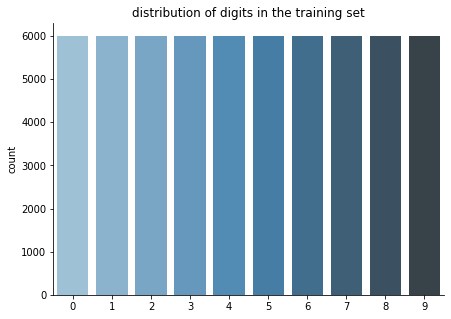

In [ ]:
plt.figure(figsize=(7,5))
sns.countplot(x=train_y.astype(int),palette='Blues_d').set(title='distribution of digits in the training set')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

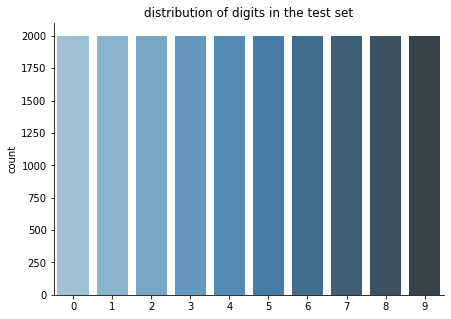

In [ ]:
plt.figure(figsize=(7,5))
sns.countplot(x=test_y.astype(int),palette='Blues_d').set(title='distribution of digits in the test set')
sns.despine(top=True, right=True, left=False, bottom=False)

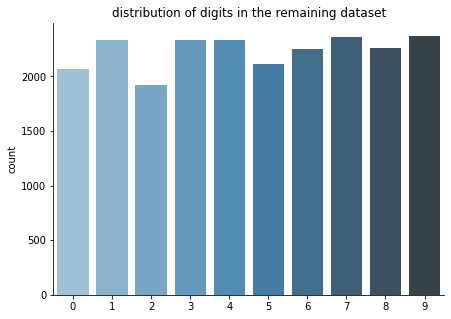

In [ ]:
plt.figure(figsize=(7,5))
sns.countplot(x=remaining_y.astype(int),palette='Blues_d').set(title='distribution of digits in the remaining dataset')
sns.despine(top=True, right=True, left=False, bottom=False)

In [ ]:
pd.DataFrame(remaining_y).value_counts()

9.0    2371
7.0    2363
3.0    2334
4.0    2333
1.0    2330
8.0    2264
6.0    2254
5.0    2110
0.0    2070
2.0    1923
dtype: int64

## Creating a validation set out of the remaining data

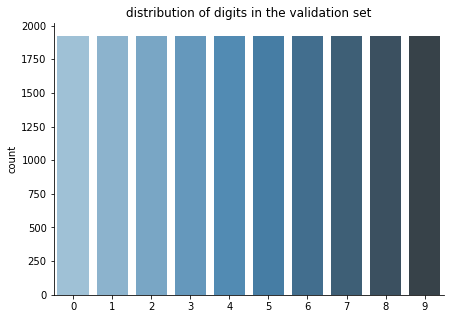

In [ ]:
valid_y=[]
valid_x=[]

df=pd.Series(remaining_y)
classes=df.unique()
for i in classes:
    s = df[df == i].sample(1923)
    valid_y.extend(s)
    valid_x.extend(remaining_x[s.index])
    
valid_x=np.array(valid_x)
valid_y=np.array(valid_y)

plt.figure(figsize=(7,5))
sns.countplot(x=valid_y.astype(int),palette='Blues_d').set(title='distribution of digits in the validation set')
sns.despine(top=True, right=True, left=False, bottom=False)



In [ ]:
def get_gray_pic(photo,label,num1,num2):
    samp=(photo)[num1:num2]
    num=len(samp)
    fig, axes = plt.subplots(nrows=1, ncols=num,figsize=(15,15))
    for j in range(0,(num)):
        img = samp[j,:,:,0]
        axes[j].imshow(img,cmap='gray')
        axes[j].axis('off')
        axes[j].set_title(f'label={label[num1+j]}')    

    plt.show()


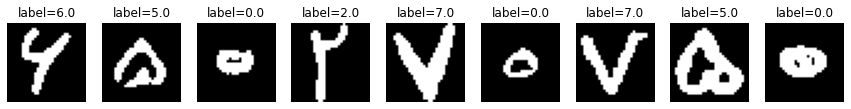

In [ ]:
get_gray_pic(train_x,train_y,0,9)

As you can see, the training set is shuffled

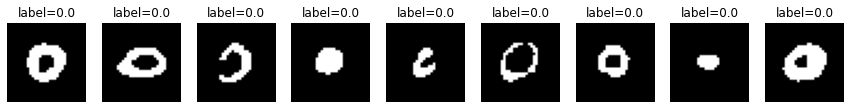

In [ ]:
get_gray_pic(test_x,test_y,0,9)

The test set is not shuffled and needs to be shuffled

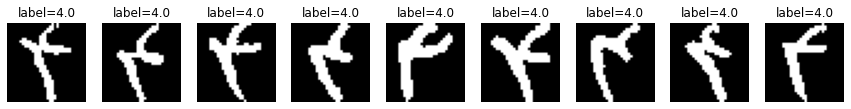

In [ ]:
get_gray_pic(valid_x,valid_y,0,9)

The validation set is not shuffled and needs to be shuffled

### Shuffling test and validation data

In [ ]:
from sklearn.utils import shuffle
test_x, test_y = shuffle(test_x, test_y, random_state=0)
valid_x, valid_y = shuffle(valid_x, valid_y, random_state=0)

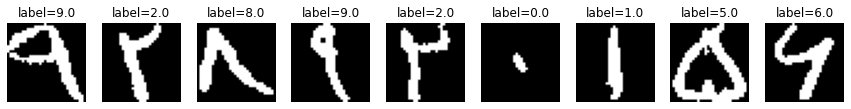

In [ ]:
get_gray_pic(test_x,test_y,0,9)

 ## Normalization of the image matrices

In [ ]:
train_x=train_x/255.
test_x=test_x/255.
valid_x=valid_x/255.

# Converting the labels into one-hot vectors

In [ ]:
train_y = to_categorical(train_y, num_classes = 10)
test_y = to_categorical(test_y, num_classes = 10)
valid_y = to_categorical(valid_y, num_classes = 10)

## Creating image generators for training and validation sets

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##data generator for training data
datagen_t = ImageDataGenerator(  
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1) 

##data generator for validation data
datagen_v = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1)  

datagen_t.fit(train_x)
datagen_v.fit(valid_x)
###generating gray images
train_generator=datagen_t.flow(train_x,train_y,batch_size=32)
valid_generator=datagen_v.flow(valid_x,valid_y,batch_size=32)

# Model configuration :

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D

In [ ]:
def model_config_1(train_x):

    input = Input(shape=train_x.shape[1:],name = 'input_layer' )
    x=Conv2D(32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_1')(input)
    x =BatchNormalization(name = 'B_N_of_layer_1')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer1')(x)
    x=Dropout(0.1,name='D_O_of_layer1')(x)

    x=Conv2D(64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_2')(x)
    x =BatchNormalization(name = 'B_N_of_layer_2')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer2')(x)
    x=Dropout(0.1,name='D_O_of_layer2')(x)

    x =Flatten(name='flat_layer')(x)
    x=Dense(1024, activation = "relu")(x)
    x=Dropout(0.5,name='D_O_of_layer3')(x)

    output=Dense(10, activation = "softmax",name='output_layer')(x)
      
    model = Model(input, output)

    return model

In [ ]:
model_config_1(train_x).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 1)]       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 32, 32, 32)        832       
                                                                 
 B_N_of_layer_1 (BatchNormal  (None, 32, 32, 32)       128       
 ization)                                                        
                                                                 
 M_P_of_layer1 (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 D_O_of_layer1 (Dropout)     (None, 16, 16, 32)        0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 16, 16, 64)        1849

In [ ]:
step=len(train_y)//32
step_v=len(valid_y)//32


### creating a function for compiling the model's settings

def comp(model,lr,opt):
    if opt=='sgd':
        optimum=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    if opt=='adam':
        optimum=tf.keras.optimizers.Adam(learning_rate=lr)
    if opt=='rmsprop':
        optimum=tf.keras.optimizers.RMSprop(learning_rate=lr,rho=0.99)
    if opt=='nadam':
        optimum=tf.keras.optimizers.Nadam(learning_rate=lr)
    
    model.compile(optimizer=optimum,loss='categorical_crossentropy', metrics=['accuracy'])
    
### creating a function for fitting the cnn model to data

def fit_model(model,train_generator,valid_generator , epoch):
    
        history =  model.fit(train_generator, epochs=epoch, validation_data=valid_generator, steps_per_epoch= step , validation_steps=step_v  )
        return history

In [ ]:
def plot_model(history):
    df=pd.DataFrame(history.history)
    fig, axs = plt.subplots(1, 2,figsize=(15,5))
    axs[0].plot(df['val_loss'])
    axs[0].plot(df['loss'])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['validation loss','training loss'], loc='upper right')
    axs[0].set_title('Loss of train/validation sets vs Epochs')
    axs[1].plot(df['val_accuracy'])
    axs[1].plot(df['accuracy'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].legend(['validation accuracy','training accuracy'], loc='lower right')
    axs[1].set_title('Accuracy of train/validation sets vs Epochs')
    plt.show()

## Begin Training :

In [ ]:
model_1=model_config_1(train_x)

comp(model_1,0.001,'adam')

history_1=fit_model(model_1,train_generator,valid_generator,10)

Epoch 1/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1324 - accuracy: 0.9594 - val_loss: 0.1859 - val_accuracy: 0.9513
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0684 - accuracy: 0.9798 - val_loss: 0.1516 - val_accuracy: 0.9588
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0564 - accuracy: 0.9847 - val_loss: 0.0577 - val_accuracy: 0.9848
Epoch 4/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0565 - accuracy: 0.9848 - val_loss: 0.0387 - val_accuracy: 0.9885
Epoch 5/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0521 - accuracy: 0.9859 - val_loss: 0.0600 - val_accuracy: 0.9845
Epoch 6/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0482 - accuracy: 0.9870 - val_loss: 0.0734 - val_accuracy: 0.9842
Epoch 7/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0458 - accuracy: 0.9877 - val_loss: 0.0518 -

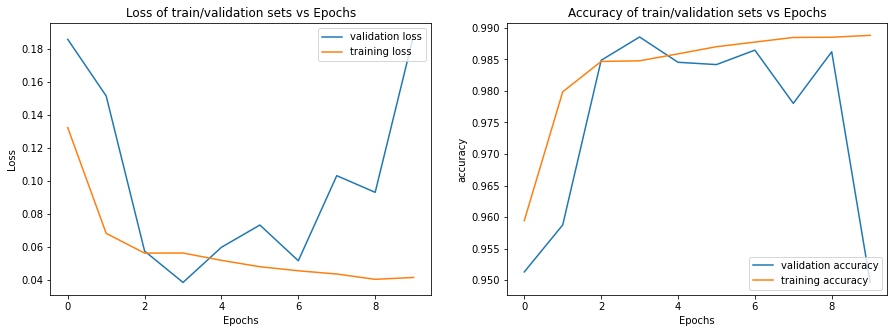

In [ ]:
plot_model(history_1)

In [ ]:
model_2=model_config_1(train_x)

comp(model_2,0.00085,'adam')

history_2=fit_model(model_2,train_generator,valid_generator,8)

Epoch 1/8
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1230 - accuracy: 0.9620 - val_loss: 0.0815 - val_accuracy: 0.9759
Epoch 2/8
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0596 - accuracy: 0.9823 - val_loss: 0.1525 - val_accuracy: 0.9636
Epoch 3/8
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0520 - accuracy: 0.9849 - val_loss: 0.0423 - val_accuracy: 0.9893
Epoch 4/8
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0464 - accuracy: 0.9866 - val_loss: 0.0910 - val_accuracy: 0.9803
Epoch 5/8
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0460 - accuracy: 0.9872 - val_loss: 0.0573 - val_accuracy: 0.9860
Epoch 6/8
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0438 - accuracy: 0.9886 - val_loss: 0.0753 - val_accuracy: 0.9800
Epoch 7/8
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0382 - accuracy: 0.9894 - val_loss: 0.0532 - val_ac

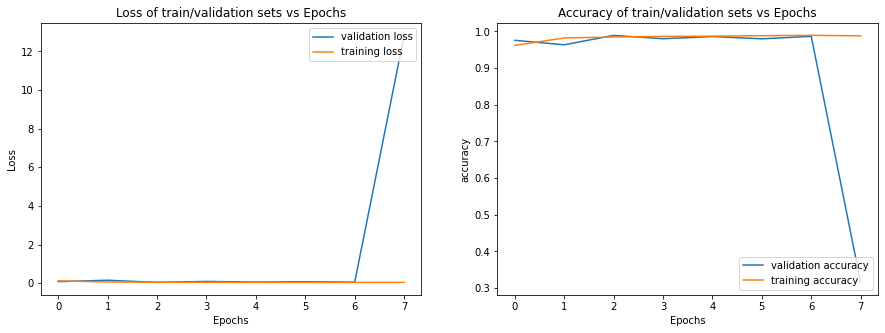

In [ ]:
plot_model(history_2)

In [ ]:
model_3=model_config_1(train_x)

comp(model_3,0.005,'adam')

history_3=fit_model(model_3,train_generator,valid_generator,10)

Epoch 1/10
1875/1875 [==============================] - 32s 16ms/step - loss: 0.3481 - accuracy: 0.9200 - val_loss: 25.2169 - val_accuracy: 0.2756
Epoch 2/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.2207 - accuracy: 0.9521 - val_loss: 0.2964 - val_accuracy: 0.9467
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2587 - accuracy: 0.9536 - val_loss: 0.2836 - val_accuracy: 0.9490
Epoch 4/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2525 - accuracy: 0.9570 - val_loss: 0.1988 - val_accuracy: 0.9769
Epoch 5/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.2375 - accuracy: 0.9612 - val_loss: 1.7392 - val_accuracy: 0.9405
Epoch 6/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2247 - accuracy: 0.9624 - val_loss: 0.1599 - val_accuracy: 0.9758
Epoch 7/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2813 - accuracy: 0.9572 - val_loss: 0.2128 

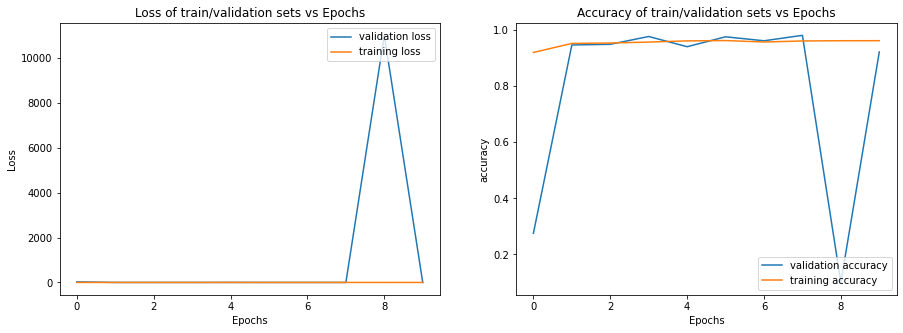

In [ ]:
plot_model(history_3)

In [ ]:
model_4=model_config_1(train_x)

comp(model_4,0.0085,'sgd')

history_4=fit_model(model_4,train_generator,valid_generator,10)

Epoch 1/10
1875/1875 [==============================] - 78s 18ms/step - loss: 0.2067 - accuracy: 0.9345 - val_loss: 1.1698 - val_accuracy: 0.7735
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0690 - accuracy: 0.9788 - val_loss: 0.2110 - val_accuracy: 0.9428
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0516 - accuracy: 0.9844 - val_loss: 0.0585 - val_accuracy: 0.9831
Epoch 4/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0441 - accuracy: 0.9864 - val_loss: 0.1596 - val_accuracy: 0.9506
Epoch 5/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0385 - accuracy: 0.9884 - val_loss: 0.3959 - val_accuracy: 0.8783
Epoch 6/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0349 - accuracy: 0.9889 - val_loss: 0.0368 - val_accuracy: 0.9881
Epoch 7/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0332 - accuracy: 0.9896 - val_loss: 0.0885 -

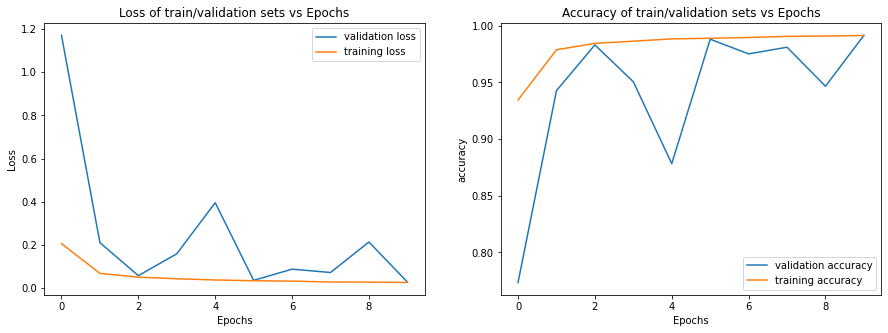

In [ ]:
plot_model(history_4)

In [ ]:
model_5=model_config_1(train_x)

comp(model_5,0.01,'sgd')

history_5=fit_model(model_5,train_generator,valid_generator,10)

Epoch 1/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2126 - accuracy: 0.9331 - val_loss: 0.3893 - val_accuracy: 0.8562
Epoch 2/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0672 - accuracy: 0.9796 - val_loss: 0.0679 - val_accuracy: 0.9802
Epoch 3/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0527 - accuracy: 0.9843 - val_loss: 0.0809 - val_accuracy: 0.9777
Epoch 4/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0412 - accuracy: 0.9872 - val_loss: 0.1042 - val_accuracy: 0.9714
Epoch 5/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0370 - accuracy: 0.9886 - val_loss: 0.0471 - val_accuracy: 0.9866
Epoch 6/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0330 - accuracy: 0.9896 - val_loss: 0.0350 - val_accuracy: 0.9900
Epoch 7/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0335 - accuracy: 0.9894 - val_loss: 0.0444 -

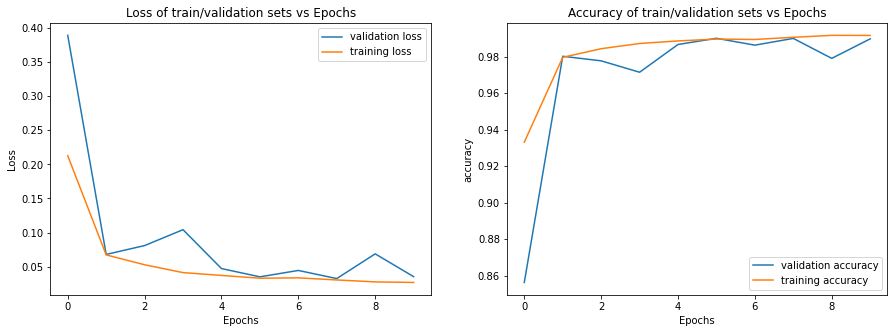

In [ ]:
plot_model(history_5)

In [ ]:
model_6=model_config_1(train_x)

comp(model_6,0.015,'sgd')

history_6=fit_model(model_6,train_generator,valid_generator,15)

Epoch 1/15
1875/1875 [==============================] - 33s 18ms/step - loss: 0.2150 - accuracy: 0.9346 - val_loss: 1.5839 - val_accuracy: 0.7279
Epoch 2/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0702 - accuracy: 0.9787 - val_loss: 0.1126 - val_accuracy: 0.9675
Epoch 3/15
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0558 - accuracy: 0.9831 - val_loss: 0.1669 - val_accuracy: 0.9460
Epoch 4/15
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0467 - accuracy: 0.9858 - val_loss: 0.0425 - val_accuracy: 0.9881
Epoch 5/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0396 - accuracy: 0.9882 - val_loss: 0.0416 - val_accuracy: 0.9878
Epoch 6/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0378 - accuracy: 0.9883 - val_loss: 0.0546 - val_accuracy: 0.9846
Epoch 7/15
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0326 - accuracy: 0.9898 - val_loss: 0.0629 -

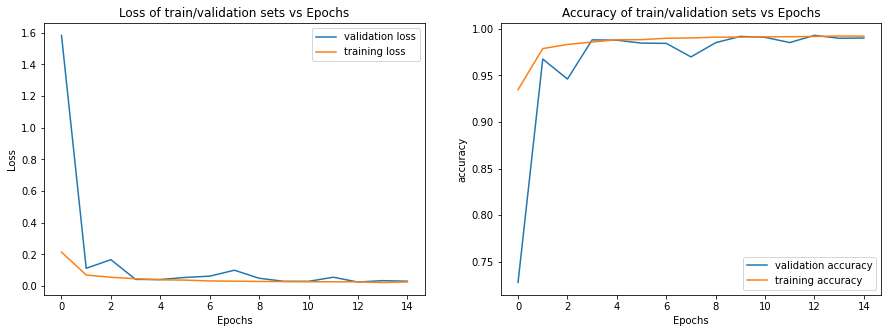

In [ ]:
plot_model(history_6)

In [ ]:
model_7=model_config_1(train_x)

comp(model_7,0.001,'rmsprop')

history_7=fit_model(model_7,train_generator,valid_generator,10)

Epoch 1/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1397 - accuracy: 0.9567 - val_loss: 0.8793 - val_accuracy: 0.8557
Epoch 2/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0646 - accuracy: 0.9814 - val_loss: 153.0959 - val_accuracy: 0.2157
Epoch 3/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0597 - accuracy: 0.9831 - val_loss: 285.6089 - val_accuracy: 0.1919
Epoch 4/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0560 - accuracy: 0.9847 - val_loss: 157.6754 - val_accuracy: 0.2347
Epoch 5/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0530 - accuracy: 0.9855 - val_loss: 784.0249 - val_accuracy: 0.1420
Epoch 6/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0530 - accuracy: 0.9858 - val_loss: 68.0324 - val_accuracy: 0.1758
Epoch 7/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0545 - accuracy: 0.9861 - val_loss:

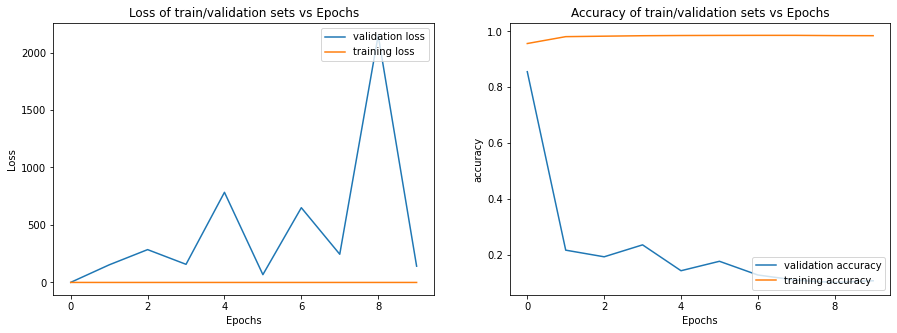

In [ ]:
plot_model(history_7)

In [ ]:
model_8=model_config_1(train_x)

comp(model_8,0.01,'rmsprop')

history_8=fit_model(model_8,train_generator,valid_generator,10)

Epoch 1/10
1875/1875 [==============================] - 32s 16ms/step - loss: 4.5172 - accuracy: 0.7681 - val_loss: 38.2935 - val_accuracy: 0.4132
Epoch 2/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.6987 - accuracy: 0.8806 - val_loss: 84011.8984 - val_accuracy: 0.1001
Epoch 3/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.6392 - accuracy: 0.8909 - val_loss: 14440.7549 - val_accuracy: 0.0999
Epoch 4/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.6833 - accuracy: 0.9031 - val_loss: 92946.2969 - val_accuracy: 0.0999
Epoch 5/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.6630 - accuracy: 0.8984 - val_loss: 42201.2266 - val_accuracy: 0.1000
Epoch 6/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.6630 - accuracy: 0.8898 - val_loss: 155638.8125 - val_accuracy: 0.0999
Epoch 7/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.7486 - accuracy: 0.881

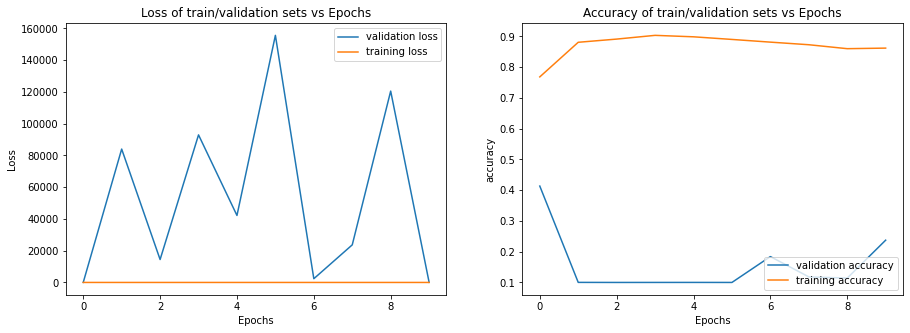

In [ ]:
plot_model(history_8)

In [ ]:
model_9=model_config_1(train_x)

comp(model_9,0.001,'nadam')

history_9=fit_model(model_9,train_generator,valid_generator,10)

Epoch 1/10
1875/1875 [==============================] - 35s 18ms/step - loss: 0.1298 - accuracy: 0.9599 - val_loss: 0.0900 - val_accuracy: 0.9739
Epoch 2/10
1875/1875 [==============================] - 37s 19ms/step - loss: 0.0657 - accuracy: 0.9813 - val_loss: 0.1264 - val_accuracy: 0.9672
Epoch 3/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0582 - accuracy: 0.9834 - val_loss: 0.1134 - val_accuracy: 0.9684
Epoch 4/10
1875/1875 [==============================] - 37s 19ms/step - loss: 0.0497 - accuracy: 0.9858 - val_loss: 0.1171 - val_accuracy: 0.9710
Epoch 5/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0509 - accuracy: 0.9861 - val_loss: 0.0935 - val_accuracy: 0.9808
Epoch 6/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0467 - accuracy: 0.9872 - val_loss: 0.0560 - val_accuracy: 0.9856
Epoch 7/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0415 - accuracy: 0.9886 - val_loss: 0.1252 -

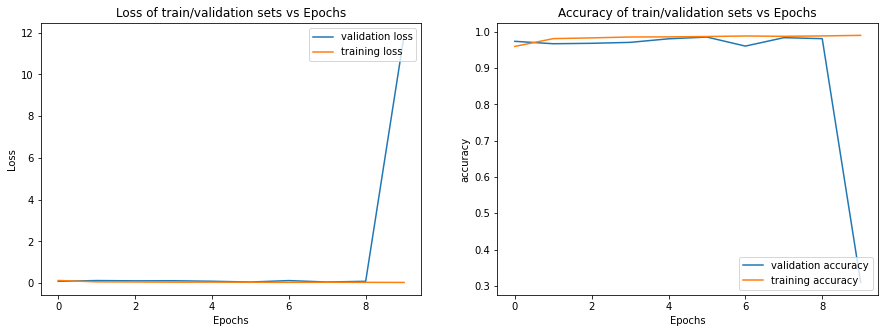

In [ ]:
plot_model(history_9)

In [ ]:
model_10=model_config_1(train_x)

comp(model_10,0.005,'nadam')

history_10=fit_model(model_10,train_generator,valid_generator,10)

Epoch 1/10
1875/1875 [==============================] - 37s 19ms/step - loss: 0.3687 - accuracy: 0.9257 - val_loss: 8.4357 - val_accuracy: 0.5389
Epoch 2/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1790 - accuracy: 0.9594 - val_loss: 0.1321 - val_accuracy: 0.9730
Epoch 3/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.3125 - accuracy: 0.9569 - val_loss: 0.2106 - val_accuracy: 0.9590
Epoch 4/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1923 - accuracy: 0.9648 - val_loss: 0.2353 - val_accuracy: 0.9698
Epoch 5/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2281 - accuracy: 0.9616 - val_loss: 0.1500 - val_accuracy: 0.9809
Epoch 6/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2537 - accuracy: 0.9639 - val_loss: 0.2129 - val_accuracy: 0.9769
Epoch 7/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2118 - accuracy: 0.9664 - val_loss: 0.1279 -

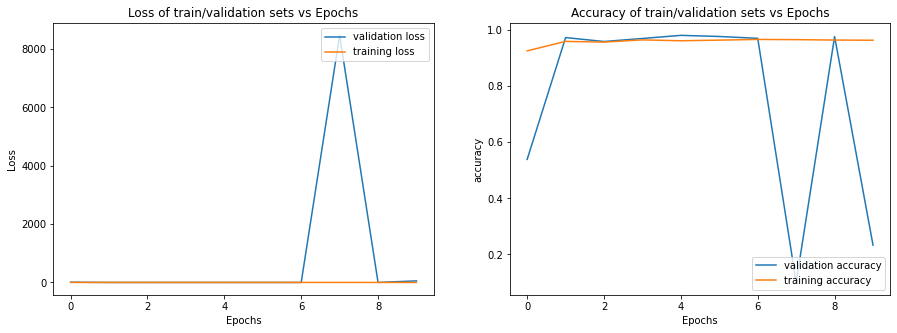

In [ ]:
plot_model(history_10)

In [ ]:
model_11=model_config_1(train_x)

comp(model_11,0.00085,'nadam')

history_11=fit_model(model_11,train_generator,valid_generator,15)

Epoch 1/15
1875/1875 [==============================] - 34s 17ms/step - loss: 0.1211 - accuracy: 0.9619 - val_loss: 0.0875 - val_accuracy: 0.9724
Epoch 2/15
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0587 - accuracy: 0.9825 - val_loss: 0.0693 - val_accuracy: 0.9781
Epoch 3/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0484 - accuracy: 0.9860 - val_loss: 0.0821 - val_accuracy: 0.9751
Epoch 4/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0454 - accuracy: 0.9866 - val_loss: 0.0921 - val_accuracy: 0.9745
Epoch 5/15
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0436 - accuracy: 0.9879 - val_loss: 0.0356 - val_accuracy: 0.9910
Epoch 6/15
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0406 - accuracy: 0.9885 - val_loss: 0.0445 - val_accuracy: 0.9878
Epoch 7/15
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0370 - accuracy: 0.9897 - val_loss: 0.0746 -

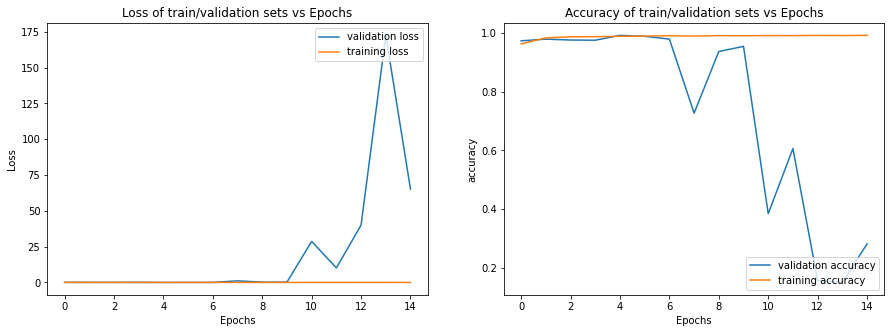

In [ ]:
plot_model(history_11)

In [ ]:
def model_config_2(train_x):

    input = Input(shape=train_x.shape[1:],name = 'input_layer' )
    x=Conv2D(32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_1')(input)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer1')(x)
    x=Dropout(0.25,name='D_O_of_layer1')(x)

    x=Conv2D(64, kernel_size = (3,3), activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_2')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer2')(x)
    x=Dropout(0.25,name='D_O_of_layer2')(x)

    x =Flatten(name='flat_layer')(x)
    x=Dense(512, activation = "relu")(x)
    x=Dropout(0.5,name='D_O_of_layer3')(x)

    output=Dense(10, activation = "softmax",name='output_layer')(x)
      
    model = Model(input, output)

    return model

In [ ]:
model_config_2(train_x).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 1)]       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 32, 32, 32)        832       
                                                                 
 M_P_of_layer1 (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 D_O_of_layer1 (Dropout)     (None, 16, 16, 32)        0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 14, 14, 64)        18496     
                                                                 
 M_P_of_layer2 (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                           

In [ ]:
model_12=model_config_2(train_x)

comp(model_12,0.00085,'adam')

history_12=fit_model(model_12,train_generator,valid_generator,15)

Epoch 1/15
1875/1875 [==============================] - 39s 15ms/step - loss: 0.6457 - accuracy: 0.7834 - val_loss: 0.3668 - val_accuracy: 0.8739
Epoch 2/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3152 - accuracy: 0.8975 - val_loss: 0.2521 - val_accuracy: 0.9185
Epoch 3/15
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2584 - accuracy: 0.9176 - val_loss: 0.2038 - val_accuracy: 0.9303
Epoch 4/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2270 - accuracy: 0.9283 - val_loss: 0.1755 - val_accuracy: 0.9423
Epoch 5/15
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1996 - accuracy: 0.9373 - val_loss: 0.1615 - val_accuracy: 0.9476
Epoch 6/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1801 - accuracy: 0.9426 - val_loss: 0.1381 - val_accuracy: 0.9565
Epoch 7/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1636 - accuracy: 0.9490 - val_loss: 0.1284 -

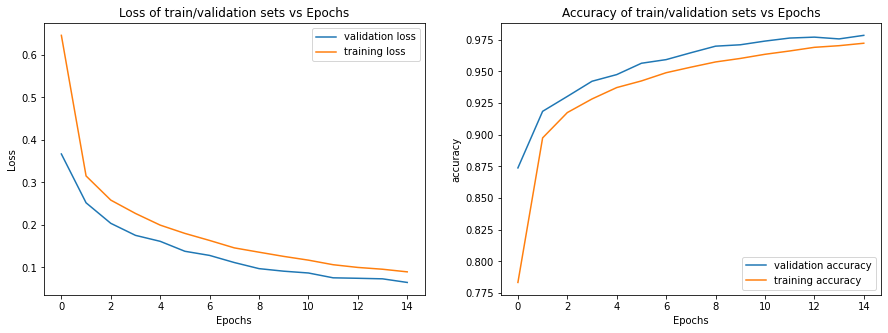

In [ ]:
plot_model(history_12)

In [ ]:
model_13=model_config_2(train_x)

comp(model_13,0.00085,'adam')

history_13=fit_model(model_13,train_generator,valid_generator,25)

Epoch 1/25
1875/1875 [==============================] - 33s 17ms/step - loss: 0.5469 - accuracy: 0.8177 - val_loss: 0.2511 - val_accuracy: 0.9180
Epoch 2/25
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2149 - accuracy: 0.9323 - val_loss: 0.1524 - val_accuracy: 0.9512
Epoch 3/25
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1562 - accuracy: 0.9511 - val_loss: 0.1166 - val_accuracy: 0.9627
Epoch 4/25
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1238 - accuracy: 0.9603 - val_loss: 0.1015 - val_accuracy: 0.9669
Epoch 5/25
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1073 - accuracy: 0.9663 - val_loss: 0.0803 - val_accuracy: 0.9735
Epoch 6/25
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0971 - accuracy: 0.9699 - val_loss: 0.0692 - val_accuracy: 0.9773
Epoch 7/25
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0866 - accuracy: 0.9729 - val_loss: 0.0703 -

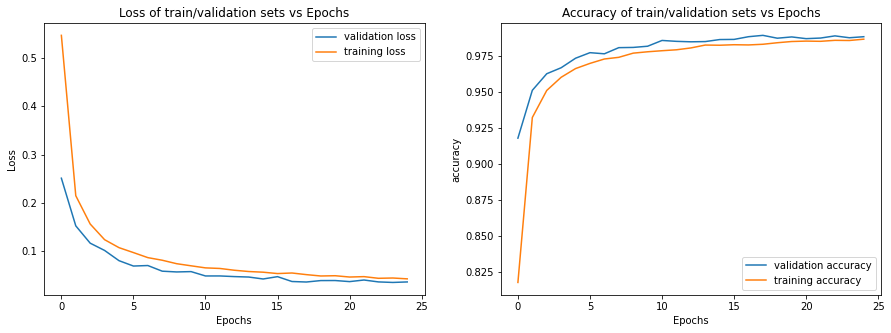

In [ ]:
plot_model(history_13)

In [ ]:
model_14=model_config_2(train_x)

comp(model_14,0.001,'adam')

history_14=fit_model(model_14,train_generator,valid_generator,30)

Epoch 1/30
1875/1875 [==============================] - 34s 18ms/step - loss: 0.5239 - accuracy: 0.8259 - val_loss: 0.2450 - val_accuracy: 0.9140
Epoch 2/30
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2060 - accuracy: 0.9347 - val_loss: 0.1491 - val_accuracy: 0.9524
Epoch 3/30
1875/1875 [==============================] - 29s 15ms/step - loss: 0.1490 - accuracy: 0.9536 - val_loss: 0.1105 - val_accuracy: 0.9639
Epoch 4/30
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1204 - accuracy: 0.9616 - val_loss: 0.0928 - val_accuracy: 0.9693
Epoch 5/30
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1011 - accuracy: 0.9681 - val_loss: 0.0863 - val_accuracy: 0.9720
Epoch 6/30
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0908 - accuracy: 0.9717 - val_loss: 0.0679 - val_accuracy: 0.9771
Epoch 7/30
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0784 - accuracy: 0.9743 - val_loss: 0.0603 -

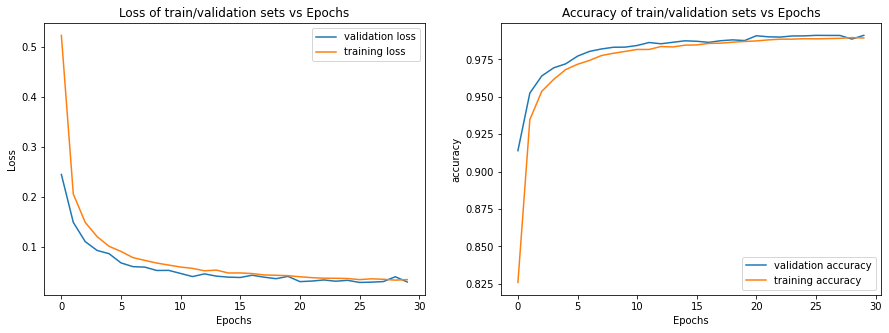

In [ ]:
plot_model(history_14)

In [ ]:
model_15=model_config_2(train_x)

comp(model_15,0.001,'sgd')

history_15=fit_model(model_15,train_generator,valid_generator,10)

Epoch 1/10
1875/1875 [==============================] - 29s 15ms/step - loss: 2.3028 - accuracy: 0.1014 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/10
1875/1875 [==============================] - 33s 18ms/step - loss: 2.3028 - accuracy: 0.0988 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 3/10
1875/1875 [==============================] - 32s 17ms/step - loss: 2.3027 - accuracy: 0.0998 - val_loss: 2.3025 - val_accuracy: 0.1002
Epoch 4/10
1875/1875 [==============================] - 27s 14ms/step - loss: 2.3026 - accuracy: 0.1013 - val_loss: 2.3025 - val_accuracy: 0.0999
Epoch 5/10
1875/1875 [==============================] - 27s 14ms/step - loss: 2.3026 - accuracy: 0.1006 - val_loss: 2.3025 - val_accuracy: 0.0999
Epoch 6/10
1875/1875 [==============================] - 31s 17ms/step - loss: 2.3027 - accuracy: 0.1008 - val_loss: 2.3024 - val_accuracy: 0.1674
Epoch 7/10
1875/1875 [==============================] - 27s 14ms/step - loss: 2.3024 - accuracy: 0.1042 - val_loss: 2.3023 -

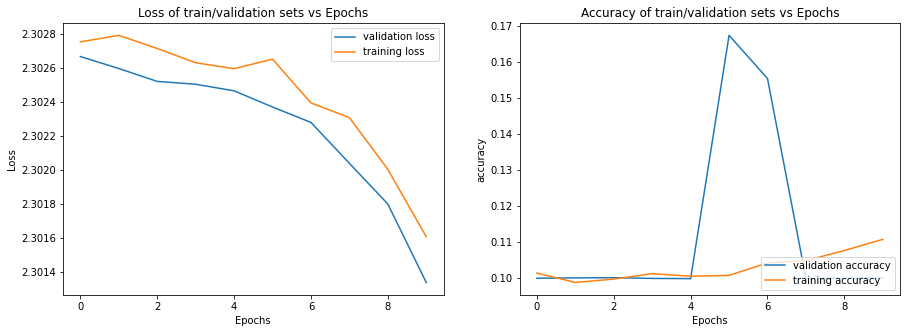

In [ ]:
plot_model(history_15)

In [ ]:
model_16=model_config_2(train_x)

comp(model_16,0.1,'sgd')

history_16=fit_model(model_16,train_generator,valid_generator,10)

Epoch 1/10
1875/1875 [==============================] - 28s 15ms/step - loss: 2.3103 - accuracy: 0.0984 - val_loss: 2.3083 - val_accuracy: 0.0999
Epoch 2/10
1875/1875 [==============================] - 27s 14ms/step - loss: 2.3098 - accuracy: 0.0998 - val_loss: 2.3085 - val_accuracy: 0.1001
Epoch 3/10
1875/1875 [==============================] - 27s 15ms/step - loss: 2.3093 - accuracy: 0.1008 - val_loss: 2.3077 - val_accuracy: 0.0999
Epoch 4/10
1875/1875 [==============================] - 32s 17ms/step - loss: 2.3092 - accuracy: 0.1032 - val_loss: 2.3077 - val_accuracy: 0.1000
Epoch 5/10
1875/1875 [==============================] - 33s 17ms/step - loss: 2.3096 - accuracy: 0.1005 - val_loss: 2.3107 - val_accuracy: 0.0999
Epoch 6/10
1875/1875 [==============================] - 27s 15ms/step - loss: 2.3094 - accuracy: 0.1005 - val_loss: 2.3095 - val_accuracy: 0.1000
Epoch 7/10
1875/1875 [==============================] - 35s 18ms/step - loss: 2.3100 - accuracy: 0.0985 - val_loss: 2.3086 -

In [ ]:
pred= model_14.predict(test_x)

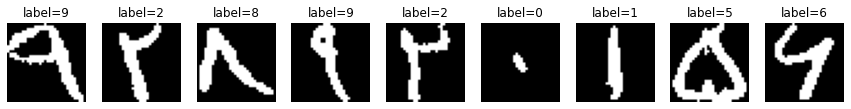

In [ ]:
get_gray_pic(test_x,np.argmax(pred,axis=1),0,9)

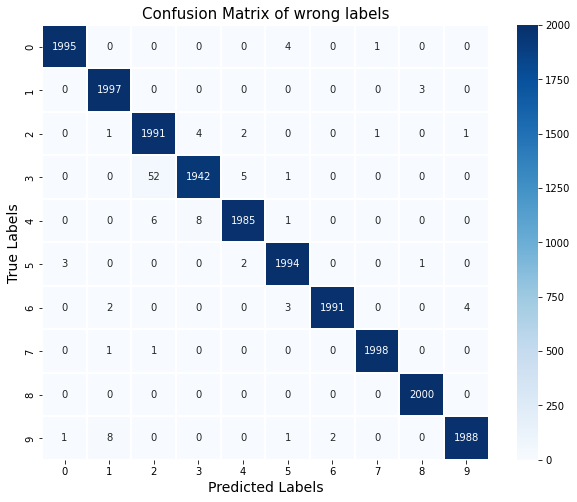

In [ ]:
cm = pd.DataFrame(confusion_matrix(np.argmax(test_y,axis=1), np.argmax(pred,axis=1)) )
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt="d")
plt.title('Confusion Matrix of wrong labels', size=15)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('True Labels', size=14)
plt.show()

In [ ]:
def display_error(pred_y_errors,true_y_errors,photo_errors,label):

    true_y_errors[true_y_errors==label]
    pred_y_errors[true_y_errors==label]
    photo_errors[true_y_errors==label]
    n=0

    fig, ax = plt.subplots(4,4,sharex=True,sharey=True,figsize=(7,7))
    for row in range(4):
        for col in range(4):
            ax[row,col].imshow(photo_errors[true_y_errors==label][n,:,:,0],cmap="gray")
            ax[row,col].set_title(f"True label :{true_y_errors[true_y_errors==label][n]}\nPredicted label :{pred_y_errors[true_y_errors==label][n]}")
            ax[row,col].axis('off')
            n += 1
    fig.tight_layout()
    plt.show()

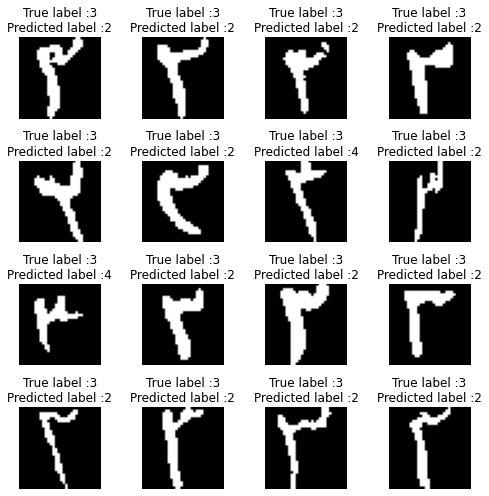

In [ ]:
true_y=np.argmax(test_y,axis=1)
pred_y=np.argmax(pred,axis=1)

errors = ( true_y - pred_y != 0)
pred_y_errors = pred_y[errors]
true_y_errors = true_y[errors]
photo_errors = test_x[errors]

display_error(pred_y_errors,true_y_errors,photo_errors,3)